# <span style="color:#0F19C9">Contenido</span>

- [Importar librerías y archivos](#importar-librerías-y-archivos)
- [Preprocesar características](#preprocesar-características)
- [Entrenar modelos](#entrenar-modelos)
    - [Prueba de cordura](#prueba-de-cordura)
    - [Regresión Lineal](#regresión-lineal)
    - [Ridge](#ridge)
    - [Lasso](#lasso)
    - [Regresión de Soporte de Vectores](#regresión-de-soporte-de-vectores)
    - [Regresión de Bosque Aleatorio](#regresión-de-bosque-aleatorio)
    - [Regresión de Gradiente](#regresión-de-gradiente)
- [Evaluar modelos](#evaluar-modelos)
- [Optimizar Modelo Lasso](#optimizar-modelo-lasso)
- [Estudiar Modelo Lasso](#estudiar-modelo-lasso)

# <span style="color:#0F19C9">Importar librerías y archivos</span>

Vamos a importar las librerías para el manejo de dataframes y las correspondientes para construir modelos de Machine Learning. Decidimos no importar el archivo de Outliers para mejorar el entrenamiento del modelo.

In [232]:
# Importar librerías de manejo de dataframes y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Importar librería de preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Importar librerías de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Importar librería para evaluación de modelos
from sklearn.metrics import mean_squared_error

In [233]:
# Importar mi paleta de colores
juan_colors = ['#101B4B', '#545E85', '#A3A8B2',
               '#E7E7E7', '#0F19C9', '#F6D673']

# Crear la paleta de colores personalizada
colors = [juan_colors[5], juan_colors[0]]
juan_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Configurar la fuente de los gráficos
plt.rc('font', family='Georgia', size=12)

In [234]:
# Importar los archivos con las publicaciones
mexico = pd.read_csv('../Data/Mexico.csv')
norteno = pd.read_csv('../Data/Norteno.csv')
popular = pd.read_csv('../Data/Popular.csv')

In [235]:
# Concatenar los archivos
df = pd.concat([mexico,
                norteno,
                popular])

# Borrar dataframes temporales
del ([mexico, norteno, popular])

In [236]:
# Formatear la columna Fecha y Hora
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], utc=True)
df['Fecha y Hora'] = df['Fecha y Hora'].dt.tz_convert('America/Bogota')

# Mostrar 3 registros aleatorios
df.sample(3)

,Artista,Seguidores,Tipo,Fecha y Hora,KPI,Likes,Comentarios,Caption,Palabras en Caption,Número de hashtags,Hashtags
24,Uriel Henao,50400,Reel,2024-07-21 19:19:02-05:00,0.007778,392,15,"""QUE INSEGURIDAD TAN HP"", Así se titula este c...",60,0,[]
36,Grupo Dominio,70100,Carrusel,2024-08-23 14:35:13-05:00,0.003124,219,0,Un Increíble Show en “Santa Rosa sur de Bolíva...,18,5,"['#santarosa', '#show', '#dominio', '#fotos', ..."
60,Bobby Pulido,162000,Carrusel,2024-09-07 21:54:49-05:00,0.004105,665,10,Voy desvelado 🎶🤠 @bobbypulido425 en el escenar...,18,5,"['#ARRE2024', '#BandamaxEnArre', '#Festival', ..."


In [237]:
# Mostrar la información general del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 0 to 68
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                         
---  ------               --------------  -----                         
 0   Artista              214 non-null    object                        
 1   Seguidores           214 non-null    int64                         
 2   Tipo                 214 non-null    object                        
 3   Fecha y Hora         214 non-null    datetime64[ns, America/Bogota]
 4   KPI                  214 non-null    float64                       
 5   Likes                214 non-null    int64                         
 6   Comentarios          214 non-null    int64                         
 7   Caption              213 non-null    object                        
 8   Palabras en Caption  214 non-null    int64                         
 9   Número de hashtags   214 non-null    int64                         
 10  Hashtags            

# <span style="color:#0F19C9">Preprocesar características</span>

Queremos determinar el KPI de las diferentes publicaciones, por lo que construiremos una regresión lineal basándonos en las otras características que podamos crear. La columna objetivo es `KPI`. Sin embargo, la columna `Artista`, `Seguidores`, `Likes`, `Comentarios`, `Caption` y `Hashtags` no las usaremos porque algunas de ellas no las controlamos en una estrategia de publicación y otras porque, como lo vimos en el análisis, como la columna de Comentarios, no nos aporta mayor información al modelo.

In [238]:
# Eliminar columnas innecesarias para el modelo
df = df[['Tipo', 'Fecha y Hora', 'Palabras en Caption', 'Número de hashtags', 'KPI']]
df.sample(3)

,Tipo,Fecha y Hora,Palabras en Caption,Número de hashtags,KPI
11,Carrusel,2024-08-13 19:38:48-05:00,54,0,8.365900e-03
25,Carrusel,2024-09-16 08:11:46-05:00,18,0,4.285714e-07
17,Carrusel,2024-09-05 09:04:21-05:00,30,2,1.212302e-02


In [239]:
# Crear One-Hot Encoder con la columna Tipo
df = pd.concat([df,
                pd.get_dummies(df['Tipo'], prefix='Tipo',
                               drop_first=True, dtype=int)], axis=1)
df.drop('Tipo', axis=1, inplace=True)

In [240]:
# Extraer información de la columna Fecha y Hora
df['Día de la publicación'] = df['Fecha y Hora'].dt.day
df['Día de la semana'] = df['Fecha y Hora'].dt.dayofweek
df['Hora de publicación'] = df['Fecha y Hora'].dt.hour
df.drop('Fecha y Hora', axis=1, inplace=True)

In [241]:
# Organizar las columnas
df = df[['Palabras en Caption', 'Número de hashtags', 'Tipo_Foto',
         'Tipo_Reel', 'Tipo_Video', 'Día de la publicación', 'Día de la semana',
         'Hora de publicación', 'KPI']]

# Separar los datos en entrenamiento y validación
train_df, test_df = train_test_split(df, test_size=0.2)

# Separar características
target = 'KPI'
categories = ['Tipo_Foto', 'Tipo_Reel', 'Tipo_Video']
features = [column for column in df.columns if (
    column not in target) and (column not in categories)]

In [242]:
# Estandarizar las columnas
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

# Mostrar 3 registros aleatorios de entrenamiento
train_df.sample(3)

,Palabras en Caption,Número de hashtags,Tipo_Foto,Tipo_Reel,Tipo_Video,Día de la publicación,Día de la semana,Hora de publicación,KPI
65,-0.509383,-0.238966,0,1,0,0.448683,-1.657769,1.072894,0.002031
43,-0.800379,0.409656,0,0,0,0.033954,-1.095312,0.133012,0.000043
41,-0.315387,-0.671380,1,0,0,-0.380774,0.592060,-0.054964,0.002668


Una vez establecimos las columnas importantes para nuestro contenido, extraemos la mayor cantidad de información de ellas y finalmente las estandarizamos para que ninguna de ellas represente un sesgo para nuestro modelo.

# <span style="color:#0F19C9">Entrenar modelos</span>

In [243]:
# Crear diccionario de métricas
models = {}

## <span style="color:#0F19C9">Prueba de Cordura</span>

In [244]:
# Encontrar la mejor constante para la prueba
best_const = 0
best_rmse = 1

for constant in np.linspace(test_df[target].min(), test_df[target].max(), num=100):
    predictions = np.array(
        [constant] * test_df[features + categories].shape[0])
    rmse = mean_squared_error(predictions, test_df[target])**0.5
    if rmse < best_rmse:
        best_rmse = rmse
        best_const = constant

predictions = np.array(
        [best_const] * test_df[features + categories].shape[0])
print(f'El menor RMSE fue {best_rmse} con la constante {best_const}')
models['Prueba de Cordura'] = best_rmse

El menor RMSE fue 0.0041258506414918305 con la constante 0.004631380952380953


## <span style="color:#0F19C9">Regresión Lineal</span>

In [245]:
# Entrenar modelo de Regresión Lineal
model_1 = LinearRegression()
model_1.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_1.predict(test_df[features + categories])
models['Regresión Lineal'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Regresión Lineal es:',
      models['Regresión Lineal'])

El RMSE en el modelo de Regresión Lineal es: 0.00426469205017002


## <span style="color:#0F19C9">Ridge</span>

In [246]:
# Entrenar modelo de Ridge
model_2 = Ridge(alpha=1.0)
model_2.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_2.predict(test_df[features + categories])
models['Ridge'] = mean_squared_error(predictions, test_df[target])**0.5
print('El RMSE en el modelo de Ridge es:', models['Ridge'])

El RMSE en el modelo de Ridge es: 0.004264973030659442


## <span style="color:#0F19C9">Lasso</span>

In [247]:
# Entrenar modelo de Lasso
model_3 = Lasso(alpha=0.0002)
model_3.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_3.predict(test_df[features + categories])
models['Lasso'] = mean_squared_error(predictions, test_df[target])**0.5
print('El RMSE en el modelo de Lasso es:', models['Lasso'])
predicciones_lasso = predictions

El RMSE en el modelo de Lasso es: 0.004172910624609595


## <span style="color:#0F19C9">Regresión de Soporte de Vectores</span>

In [248]:
# Entrenar modelo de Regresión de Soporte de Vectores
model_4 = SVR(kernel='rbf')
model_4.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_4.predict(test_df[features + categories])
models['Regresión de Soporte de Vectores'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Regresión de Soporte de Vectores es:',
      models['Regresión de Soporte de Vectores'])

El RMSE en el modelo de Regresión de Soporte de Vectores es: 0.006844830032903316


## <span style="color:#0F19C9">Regresión de Bosque Aleatorio</span>

In [249]:
# Entrenar modelo de Regresión de Bosque Aleatorio
model_5 = RandomForestRegressor()
model_5.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_5.predict(test_df[features + categories])
models['Regresión de Bosque Aleatorio'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Regresión de Bosque Aleatorio es:',
      models['Regresión de Bosque Aleatorio'])

El RMSE en el modelo de Regresión de Bosque Aleatorio es: 0.0044480584353219325


## <span style="color:#0F19C9">Regresión de Gradiente</span>

In [250]:
# Entrenar modelo de Regresión de Gradiente
model_6 = GradientBoostingRegressor()
model_6.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_6.predict(test_df[features + categories])
models['Regresión de Gradiente'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Regresión de Gradiente es:',
      models['Regresión de Gradiente'])

El RMSE en el modelo de Regresión de Gradiente es: 0.004533516263024817


# <span style="color:#0F19C9">Evaluar modelos</span>

C:\Users\juanp\AppData\Local\Temp\ipykernel_16160\3227085178.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(models.keys()),


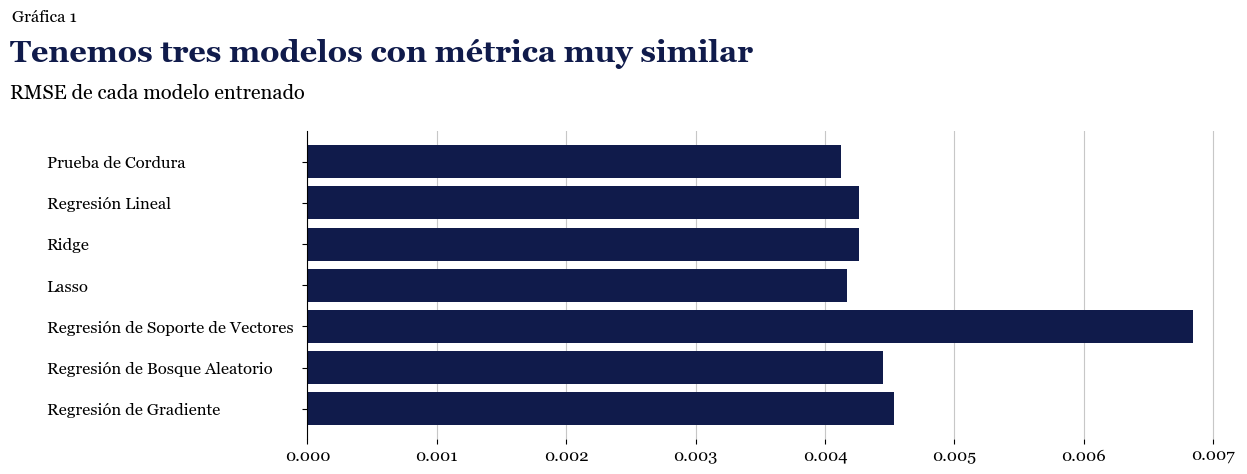

El mejor modelo fue el Lasso que tuvo un RMSE de 0.004172910624609595


In [251]:
# Hacer gráfica de métricas de modelos
fig, ax = plt.subplots(figsize=[12, 4])
plt.text(x=-0.00228, y=-3.4,
         s='Gráfica 1')
plt.title('Tenemos tres modelos con métrica muy similar',
          weight='bold', size=22,
          x=0.08, y=1.2, color=juan_colors[0])
plt.suptitle('RMSE de cada modelo entrenado',
             x=0, y=1)
plt.barh(y=list(models.keys()),
         width=list(models.values()),
         color=juan_colors[0],
         zorder=2)
ax.set_yticklabels(list(models.keys()),
                   ha='left',
                   x=-.27)
plt.grid(axis='x', alpha=0.7,
         zorder=1)
ax.spines[['top', 'bottom', 'right']].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

# Identificar el mejor modelo
best_model = sorted(models, key=models.get)[1]
print(
    f'El mejor modelo fue el {best_model} que tuvo un RMSE de {models[best_model]}')

# <span style="color:#0F19C9">Optimizar modelo Lasso</span>

Debido a que Lasso fue el modelo que menor error nos arrojó, vamos a continuar con la afinación de sus hiperparámetros buscando disminuir aún más el error, esto lo haremos con `GridSearchCV`.

In [252]:
# Definir el rango de hiperparámetros para ajustar
parametros = {
    'alpha': [0.0001, 0.0002, 0.0003, 0.0005, 0.0007, 0.001, 0.01, 0.1, 1],
    'fit_intercept': [True, False],
    'max_iter': [10, 100, 1000, 5000, 10000],
    'positive': [True, False]
}

# Definir el GridSearchCV con validación cruzada
grid_search = GridSearchCV(model_3, param_grid=parametros,
                           cv=5, scoring='neg_mean_squared_error')

# Ajustar el GridSearchCV con los datos de entrenamiento
grid_search.fit(train_df[features + categories], train_df[target])

# Obtener todos los resultados del GridSearch
resultados = grid_search.cv_results_

# Inicializar el mejor modelo válido
best_model = None
best_params = None
best_rmse = 1

# Comprobar el mejor modelo y los coeficientes
for i in range(len(resultados['mean_test_score'])):
    model = Lasso(
        alpha=resultados['params'][i]['alpha'],
        fit_intercept=resultados['params'][i]['fit_intercept'],
        max_iter=resultados['params'][i]['max_iter'],
        positive=resultados['params'][i]['positive']
    )
    model.fit(train_df[features + categories], train_df[target])

    # Checar los coeficientes
    coeficientes = model.coef_

    # Contar cuántos coeficientes son diferentes de 0
    non_zero_count = sum(c != 0 for c in coeficientes)

    # Si al menos 3 coeficientes son diferentes de 0, guardar el modelo y sus parámetros
    if non_zero_count >= 3:
        predictions = model.predict(test_df[features + categories])
        rmse = mean_squared_error(predictions, test_df[target])**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = resultados['params'][i]

# Comprobar si se encontró un modelo válido
if best_model is not None:
    print("Mejores hiperparámetros: ", best_params)
    print("Coeficientes del mejor modelo: ", best_model.coef_)
    print("Con un RMSE de", best_rmse)
else:
    print("No se encontró un modelo válido con al menos 3 coeficientes diferentes de cero.")

Mejores hiperparámetros:  {'alpha': 0.0003, 'fit_intercept': True, 'max_iter': 10, 'positive': True}
Coeficientes del mejor modelo:  [0.00023375 0.00015902 0.         0.         0.00021698 0.
 0.         0.        ]
Con un RMSE de 0.004156142040884112


In [253]:
# Definir el rango de hiperparámetros para ajustar
parametros = {
    'alpha': [0.0001, 0.0002, 0.0003, 0.0004],
    'fit_intercept': [True, False],
    'max_iter': [5, 8, 10, 12, 15],
    'positive': [True, False]
}

# Definir el GridSearchCV con validación cruzada
grid_search = GridSearchCV(model_3, param_grid=parametros,
                           cv=5, scoring='neg_mean_squared_error')

# Ajustar el GridSearchCV con los datos de entrenamiento
grid_search.fit(train_df[features + categories], train_df[target])

# Obtener todos los resultados del GridSearch
resultados = grid_search.cv_results_

# Inicializar el mejor modelo válido
best_model = None
best_params = None
best_rmse = 1

# Comprobar el mejor modelo y los coeficientes
for i in range(len(resultados['mean_test_score'])):
    model = Lasso(
        alpha=resultados['params'][i]['alpha'],
        fit_intercept=resultados['params'][i]['fit_intercept'],
        max_iter=resultados['params'][i]['max_iter'],
        positive=resultados['params'][i]['positive']
    )
    model.fit(train_df[features + categories], train_df[target])

    # Checar los coeficientes
    coeficientes = model.coef_

    # Contar cuántos coeficientes son diferentes de 0
    non_zero_count = sum(c != 0 for c in coeficientes)

    # Si al menos 3 coeficientes son diferentes de 0, guardar el modelo y sus parámetros
    if non_zero_count >= 3:
        predictions = model.predict(test_df[features + categories])
        rmse = mean_squared_error(predictions, test_df[target])**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = resultados['params'][i]

# Comprobar si se encontró un modelo válido
if best_model is not None:
    print("Mejores hiperparámetros: ", best_params)
    print("Coeficientes del mejor modelo: ", best_model.coef_)
    print("Con un RMSE de", best_rmse)
else:
    print("No se encontró un modelo válido con al menos 3 coeficientes diferentes de cero.")

Mejores hiperparámetros:  {'alpha': 0.0004, 'fit_intercept': True, 'max_iter': 5, 'positive': True}
Coeficientes del mejor modelo:  [1.40217842e-04 5.35686384e-05 0.00000000e+00 0.00000000e+00
 1.05387596e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Con un RMSE de 0.004132063968401594


In [254]:
# Reentrenamiento del modelo
model_3 = best_model
model_3.fit(train_df[features + categories], train_df[target])

# Evaluar el modelo
predictions = model_3.predict(test_df[features + categories])
models['Lasso FineTuned'] = mean_squared_error(
    predictions, test_df[target])**0.5
print('El RMSE en el modelo de Lasso reentrenado es:', models['Lasso'])
predicciones_lasso_opt = predictions

El RMSE en el modelo de Lasso reentrenado es: 0.004172910624609595


In [255]:
# Medir la diferencia de modelos
diff = 100 - ((models['Lasso FineTuned']/models['Lasso']) * 100)
print(
    f"La mejora en nuestra métrica antes del reentrenamiento y después del reentrenamiento es de {diff:.4f}%")

La mejora en nuestra métrica antes del reentrenamiento y después del reentrenamiento es de 0.9789%


C:\Users\juanp\AppData\Local\Temp\ipykernel_16160\1349577810.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['Lasso Original',


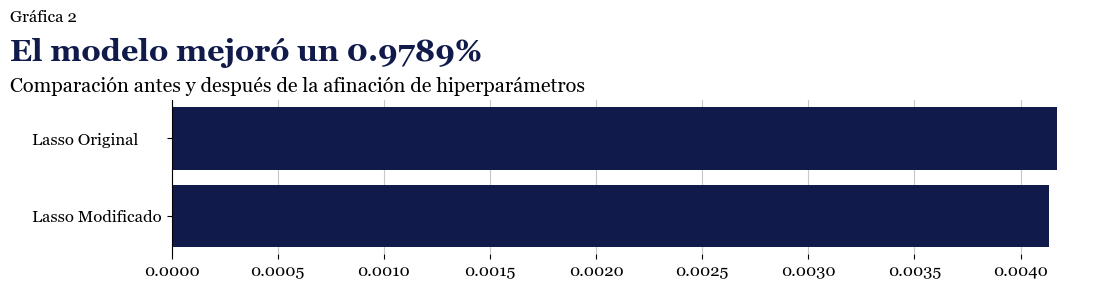

In [263]:
# Hacer gráfica de métricas de modelos
fig, ax = plt.subplots(figsize=[12, 2])
plt.text(x=-0.00076, y=-1.5,
         s='Gráfica 2')
plt.title(f'El modelo mejoró un {diff:.4f}%',
          weight='bold', size=22,
          x=0.08, y=1.2, color=juan_colors[0])
plt.suptitle('Comparación antes y después de la afinación de hiperparámetros',
             x=0.23, y=1)
plt.barh(y=['Lasso', 'Lasso FineTuned'],
         width=[models['Lasso'], models['Lasso FineTuned']],
         color=juan_colors[0],
         zorder=2)
ax.set_yticklabels(['Lasso Original',
                    'Lasso Modificado'],
                   ha='left',
                   x=-.14)
plt.grid(axis='x', alpha=0.7,
         zorder=1)
ax.spines[['top', 'bottom', 'right']].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

In [257]:
# Crear dataframe con predicciones
predictions = pd.DataFrame({
    'Datos de Prueba': test_df[target],
    'Lasso Original': predicciones_lasso,
    'Lasso Optimizado': predicciones_lasso_opt
})
predictions.sort_values('Datos de Prueba', inplace=True)

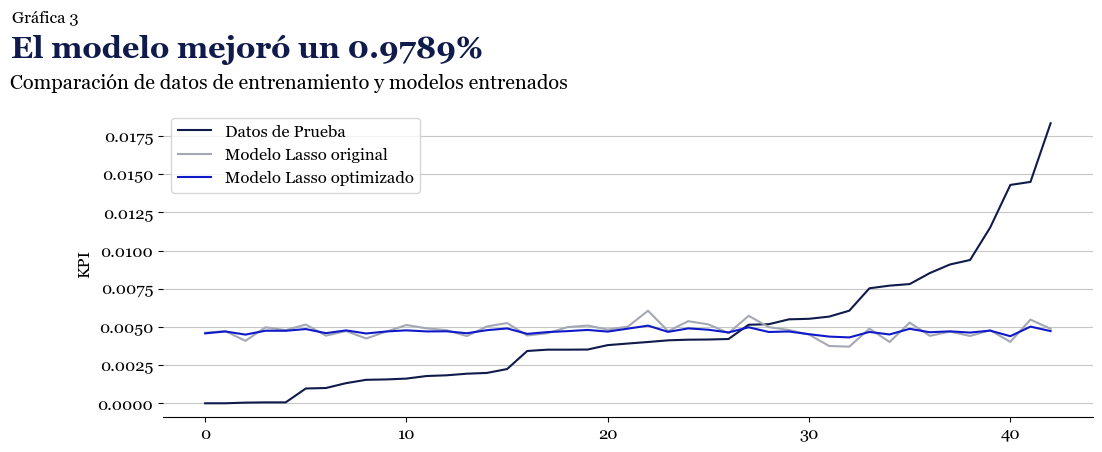

In [285]:
# Mostrar las predicciones del modelo
fig, ax = plt.subplots(figsize=[12, 4])
plt.text(x=-9.6, y=0.025,
         s='Gráfica 3')
plt.title(f'El modelo mejoró un {diff:.4f}%',
          weight='bold', size=22,
          x=0.09, y=1.14, color=juan_colors[0])
plt.suptitle('Comparación de datos de entrenamiento y modelos entrenados',
             x=0.23, y=0.97)
plt.plot(range(predictions.shape[0]),
         predictions['Datos de Prueba'],
         label='Datos de Prueba',
         color=juan_colors[0])
plt.plot(range(predictions.shape[0]),
         predictions['Lasso Original'],
         label='Modelo Lasso original',
         color=juan_colors[2])
plt.plot(range(predictions.shape[0]),
         predictions['Lasso Optimizado'],
         label='Modelo Lasso optimizado',
         color=juan_colors[4])
plt.ylabel('KPI')
plt.legend()
plt.grid(axis='y', alpha=0.7,
         zorder=1)
ax.spines[['top', 'left', 'right']].set_visible(False)
plt.show()

# <span style="color:#0F19C9">Estudiar modelo Lasso</span>

In [286]:
# Encontrar coeficientes del modelo
coeficientes = pd.DataFrame({
    'Característica': model_3.feature_names_in_,
    'Coeficiente': model_3.coef_
})

# Ordenar por valor absoluto
coeficientes['Absoluto'] = np.abs(coeficientes['Coeficiente'])
coeficientes.sort_values('Absoluto', ascending=False, inplace=True)
coeficientes.drop(columns='Absoluto', inplace=True)
coeficientes

,Característica,Coeficiente
0,Palabras en Caption,0.000140
4,Hora de publicación,0.000105
1,Número de hashtags,0.000054
2,Día de la publicación,0.000000
3,Día de la semana,0.000000
5,Tipo_Foto,0.000000
6,Tipo_Reel,0.000000
7,Tipo_Video,0.000000


C:\Users\juanp\AppData\Local\Temp\ipykernel_16160\392124291.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(coeficientes['Característica'],


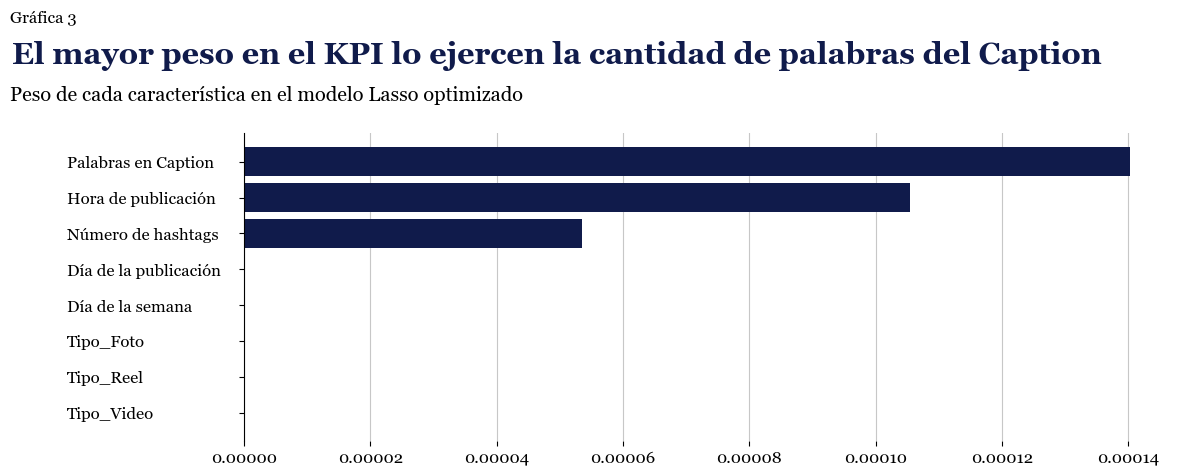

In [297]:
# Hacer gráfica de coeficientes del modelo
fig, ax = plt.subplots(figsize=[12, 4])
plt.text(x=-0.000037, y=-3.9, ha='left',
         s='Gráfica 3')
plt.title('El mayor peso en el KPI lo ejercen la cantidad de palabras del Caption',
          weight='bold', size=22, ha='left',
          x=-0.25, y=1.2, color=juan_colors[0])
plt.suptitle('Peso de cada característica en el modelo Lasso optimizado',
             x=-0.07, y=1, ha='left')
plt.barh(y=coeficientes['Característica'],
         width=coeficientes['Coeficiente'],
         color=juan_colors[0],
         zorder=2)
ax.set_yticklabels(coeficientes['Característica'],
                   ha='left',
                   x=-.18)
plt.grid(axis='x', alpha=0.7,
         zorder=1)
ax.spines[['top', 'bottom', 'right']].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

Podemos entonces concluir, a partir de la evaluación con la métrica de la Raíz del Error Cuadrático Medio, donde el mejor modelo resulta ser el menor valor de error, el mejor modelo es el llamado Lasso con un valor de RMSE de 0.004268.

De este modelo, y más específicamente de sus coeficientes, podemos ver que se penalizaron las características de Tipo, es decir, para el modelo el tipo de contenido no resultó ser lo suficientemente relevante. Así como el número de hashtags en una publicación, ni el día. Por otra parte, tenemos tres coeficientes positivos que en orden de prioridad serían:
- **Cantidad de palabras en la descripción:** Con un coeficiente de 0.000140, es la característica con mayor impacto en nuestra variable objetivo. Que sea positiva nos indica que en cuanto más palabras usemos en la descripción, tendremos un mejor KPI.
- **Hora de publicación:** Es la segunda característica con mayor impacto en nuestra variable objetivo con un coeficiente de 0.000105, también es positiva. Entonces es la segunda variable más importante para poder determinar el KPI de una publicación.
- **Día de la Semana:** Con un coeficiente de 0.000054, podemos ver que aunque si es importante para el modelo, pues no la penalizó, no tiene gran impacto sobre nuestra variable objetivo.

Es importante mencionar que, a pesar, que podemos encontrar algunas características importantes, el movimiento de las predicciones y nuestra métrica nos permiten ver que nuestros datos son insuficientes para demostrar alguna relación fuerte con nuestro KPI, pues en realidad el modelo no es capaz de encontrar una relación que le permita reducir ese error. Se recomienda conseguir nuevos datos, con nuevas características que puedan ser más determinantes en la predicción.